# Open Exploration - Uncertainties

Group 11, *EPA1361 Model-based Decision-making 18/19*

A. Werntges, H. Cheng, G. Papazotos, R. Patel, P. De Biase

## Summary

- **"No action" (zero policy) is the WORST action**: a random lever can significantly reduce the Expected Number of Deaths and Expected Annual Damage, although the costs resulted from the introduced lever could be around the same or higher than the order of the damage.

- **Dike failure probabilities (*pfail*) are the most infuential uncertainties** w.r.t. both deaths and damage:

    - `Expected annual damage`: ***pfail* at Doesburg (A.1) is the most influential uncertainty in the extreme cases** (e.g., when *A.1_pfail < .091*). In other common cases, a lower outcome of expected annual damage (e.g., < 50 million EUR) is likely to occur at scenarios with **stricter requirements on *pfail* at Deventer (A.5), Zutphen (A.3) and Cortenoever (A.2)**.
    
    - `Expected number of deaths`: ***pfail* at Zutphen (A.3) is the most infuential uncertainty** with the strictest requirement; however, *pfail* in other locations - more specifically, Deventer (A.5), Cortenoever (A.2) and Doesburg (A.1) - are also important in the case of deaths.
    
    - `Evacuation costs`: ***pfail* at Zutphen (A.3) is the most infuential uncertainty**.

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking, plotting)
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

from model.problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)
np.random.seed(42)
random.seed(42)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## 0, Experiments

In this exploration over uncertainties, we perform experiments for a two-timesteps dike model with the five-objectives problem formulation, i.e.

1. Expected annual damage
2. Dike investment costs
3. RfR investment costs
4. Evacuation costs
5. Expected number of deaths

The experiments are performed for ten sampled policies *plus zero policy* (baseline), and per policy 1,000 sampled scenarios. Both levers and uncertainties are done with lhs sampling.

In [3]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
ID_PF = 2    # assign problem_formulation_id
NR_STEPS = 2 # assign number of planning steps
dike_model, planning_steps = get_model_for_problem_formulation(ID_PF, NR_STEPS)

In [3]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=200, policies=200) # using lhs sampling

save_results(results, './results/open_exploration_uncertainties_40000runs_2steps.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 200 scenarios * 200 policies * 1 model(s) = 40000 experiments
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] 16000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 24000 cases completed
[MainProcess/INFO] 28000 cases completed
[MainProcess/INFO] 32000 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] 40000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\pvbia\OneDrive\Documentos\GitHub\MBDM-group-11\final assignment\results\open_exploration_uncertainties_40000runs_2steps.tar.gz


Wall time: 1h 56min 32s


In [4]:
results = load_results('./results/open_exploration_uncertainties_10000runs_2steps.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_10000runs_2steps.tar.gz


In [5]:
# use the same 1,000 sampled scenarios, run for zero policy
sampled_scenarios = experiments.loc[:, [u.name for u in dike_model.uncertainties]]
sampled_scenarios.drop_duplicates(inplace=True)
ref_scenarios = [Scenario(i, **scenario.to_dict())
                 for i, scenario in pd.DataFrame.from_dict(sampled_scenarios).iterrows()] # sampled scenarios

# make a policy instance for zero policy
policy0 = {'DikeIncrease': 0, 'DaysToThreat': 0, 'RfR': 0}
ref_policy = {}
for key in dike_model.levers:
    _, s = key.name.split('_')
    if ' ' in s:
        s, _ = s.split(' ')
    ref_policy.update({key.name: policy0[s]})
ref_policy0 = Policy('baseline', **ref_policy) # policy0

In [6]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=ref_scenarios, 
                                            policies=ref_policy0) # using lhs sampling

save_results(results, './results/open_exploration_uncertainties_policy0_2steps.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_policy0_2steps.tar.gz


Wall time: 7min 11s


In [6]:
results_policy0 = load_results('./results/open_exploration_uncertainties_policy0_2steps.tar.gz')

experiments_policy0, outcomes_policy0 = results_policy0

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_policy0_2steps.tar.gz


In [7]:
## concat the results of policy0 with previous experiments and outcomes

# first make copies from sampled results
experiments_w0 = experiments.copy() 
outcomes_w0 = outcomes.copy()

# then merge with results of zero policy 
experiments_w0 = pd.concat([experiments_policy0, experiments_w0], axis=0, sort=False)
experiments_w0.reset_index(drop=True, inplace=True)
experiments_w0.policy = experiments_w0.policy.apply(lambda x: str(x)) # make policy no. as strings
for key in outcomes:
    outcomes_w0.update({key: np.append(outcomes_policy0[key], outcomes_w0[key])})

## 1, The Outcomes: Boxplot and Pairwise Scatterplot

We first inspect the outcomes by boxplots. From the graphs we can see that the results for *Dike Investment Costs* and *RfR Investment Costs* are quite normally distributed (with outliers being the zero policy cases). The outcomes of *Expected Annual Damage*, *Evacuation Costs* and *Expected Number of Deaths* are highly concentrated under some given thresholds with many "outliers" beyond the cap (Q3 + 1.5 * IQR). We can also see from the pairwise scatterplots that the outcomes of *Expected Annual Damage* are highly correlated to *Expected Number of Deaths* and *Evacuation Costs* (in cases where evacuation lever is present), and different policies result in different "damage-to-deaths" ratios (the linear regression slope) across scenarios. Also note that *Dike Investment Costs* and *RfR Investment Costs* are only related to the levers, while *Evacuation Costs* depends not only on whether the lever is present but also the scale of expected damage (or uncertainties).

From the graphs we can see that **"no action" (zero policy) is the WORST action**: a random lever can significantly reduce the *Expected Number of Deaths* and *Expected Annual Damage*, although the costs resulted from the introduced lever could be around the same or higher than the order of the damage.

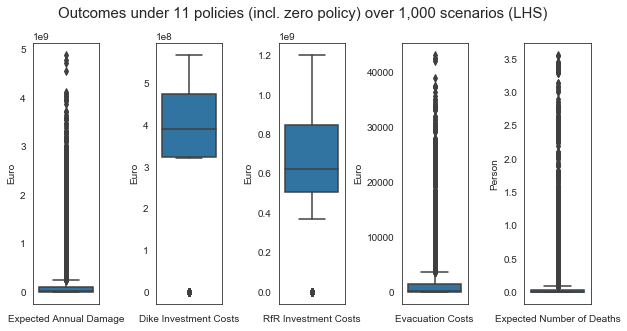

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
plt.subplots_adjust(wspace=0.85, top=0.85)
kpis = [key.name for key in dike_model.outcomes]
fig.suptitle('Outcomes under 11 policies (incl. zero policy) over 1,000 scenarios (LHS)', y=0.95, fontsize=15)

for key in kpis:
    i = kpis.index(key)
    sns.boxplot(pd.Series(outcomes_w0[key]), orient='v', ax=axes[i])
    axes[i].set_xlabel(key)
    if not key == 'Expected Number of Deaths':
        axes[i].set_ylabel('Euro') # set units for damage and costs
    else:
        axes[i].set_ylabel('Person') # set unit for number of deaths

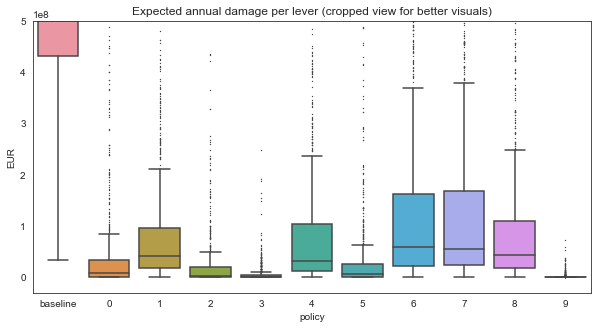

In [19]:
# check distribution of expected annual damage per lever
damage = pd.DataFrame({'policy' : experiments_w0.policy,
                       'Expected Annual Damage' : outcomes_w0['Expected Annual Damage']})

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=damage, x='policy', y='Expected Annual Damage', fliersize=0.5)
ax.set_title('Expected annual damage per lever (cropped view for better visuals)')
ax.set_ylabel('EUR')
ax.set_ybound(-3e7, 5e8) # zoom-in for better visuals

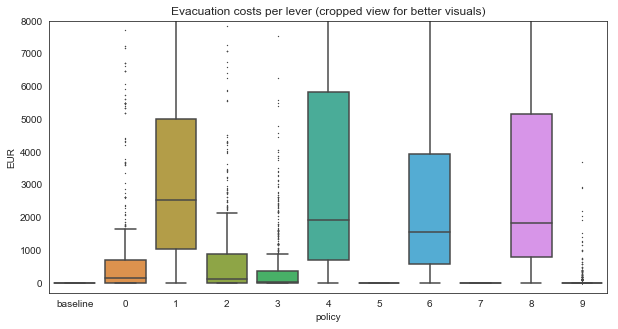

In [27]:
# check distribution of evacuation costs per lever
evacuation = pd.DataFrame({'policy' : experiments_w0.policy,
                           'Evacuation Costs' : outcomes_w0['Evacuation Costs']})

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=evacuation, x='policy', y='Evacuation Costs', fliersize=0.5)
ax.set_title('Evacuation costs per lever (cropped view for better visuals)')
ax.set_ylabel('EUR')
ax.set_ybound(-3e2, 8e3) # zoom-in for better visuals

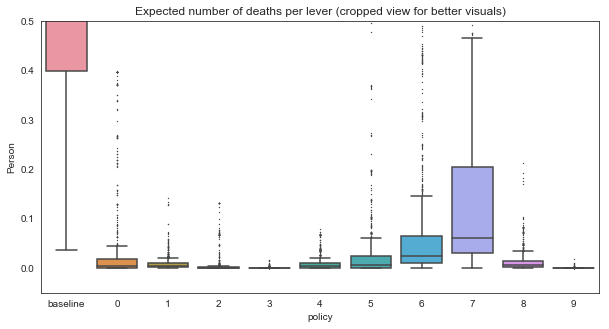

In [22]:
# check distribution of expected number of deaths per lever
deaths = pd.DataFrame({'policy' : experiments_w0.policy,
                       'Expected Number of Deaths' : outcomes_w0['Expected Number of Deaths']})

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=deaths, x='policy', y='Expected Number of Deaths', fliersize=0.5)
ax.set_title('Expected number of deaths per lever (cropped view for better visuals)')
ax.set_ylabel('Person')
ax.set_ybound(-0.05, 0.5) # zoom-in for better visuals

### *Pairwise plot showing sampled policies and also zero policy*

[MainProcess/INFO] no time dimension found in results


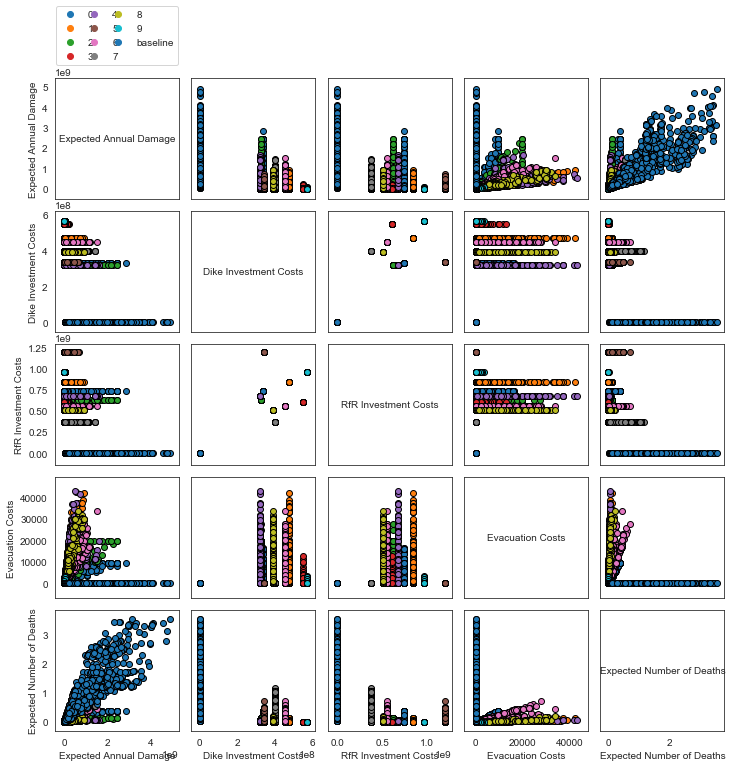

In [24]:
fig, ax = pairs_plotting.pairs_scatter(experiments_w0, outcomes_w0, group_by='policy', legend=True)
fig.set_size_inches([12, 12])

### *Pairwise plot showing only sampled policies*

[MainProcess/INFO] no time dimension found in results


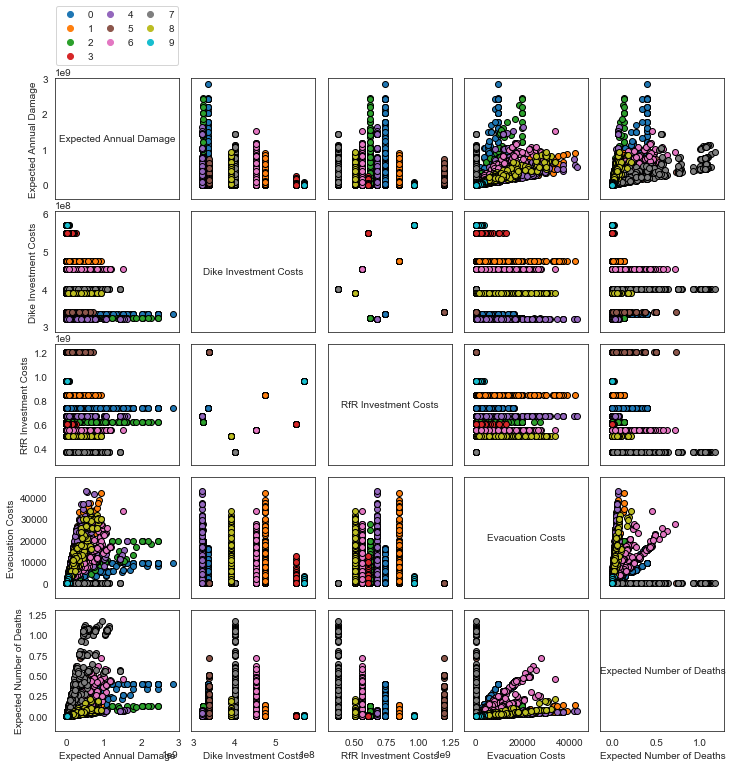

In [25]:
fig, ax = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy', legend=True)
fig.set_size_inches([12, 12])

## 2, Feature Scoring

We then perform feature scoring for the outcomes to find out on which outcome does which uncertainty has the largest influence. We drop the dike and RfR investment costs here as they are irrelevant to uncertainties. Here we analyse **only the experiments with sampled levers (i.e., without the results of zero policy)** as we learned previously no action is the worst action.

From the results, we see that both *Expected Annual Damage* and *Expected Number of Deaths* are primarily influenced by **dike failure probability (*pfail*) at Doesburg (A.1) and Zutphen (A.3)**, while the growth rates of breach width (*Brate*) seem to have limited influence on expected damage. ***Evacuation Costs* is significantly influenced by *pfail* at Zutphen (A.3)**.

In [11]:
# remove dike and RfR investment costs as they are irrelevant to uncertainties
del outcomes['Dike Investment Costs']
del outcomes['RfR Investment Costs']

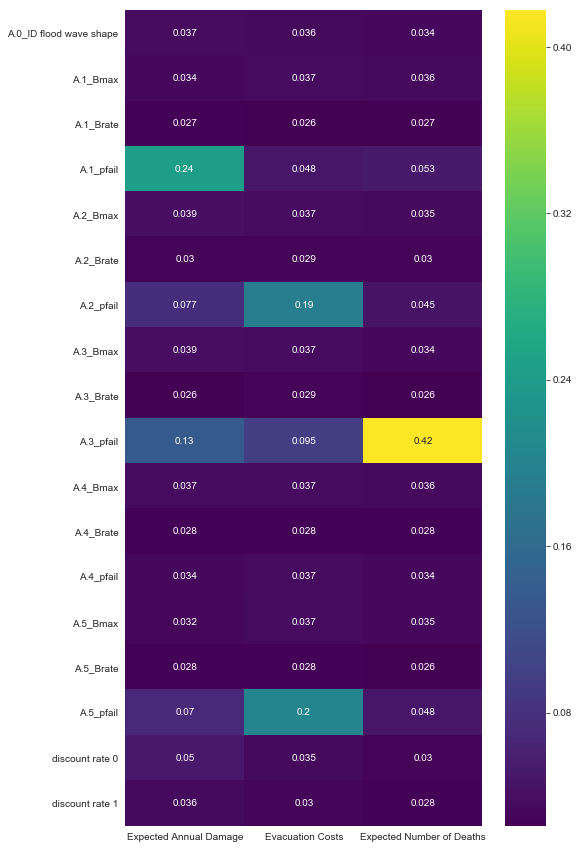

In [12]:
x = experiments.drop(columns = [l.name for l in dike_model.levers]+['policy', 'model'])
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y, mode=RuleInductionType.REGRESSION)
plt.figure(figsize = (8,15))
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

## 3, Dimensional Stacking & PRIM

We can further apply dimensional stacking to create a heatmap showing the influences of the most important uncertainties, and PRIM to identify the range of those uncertainties. We plot it for expected damage and number of deaths. 

### a. Expected Annual Damage < 50 million EUR

From the boxplots and pairwise scatterplots above, we learned that *Dike Investment Costs* fall roughly in the range of 0.3 ~ 0.5 billion EUR, whereas *RfR Investment Costs* are with a higher range of 0.4 ~ 1.2 billion EUR. Expected annual damage is at a lower scale then the investment costs with a mean value of roughly ~50 million EUR although it differs across the levers introduced. Therefore, we set 50 million EUR as the threshold for subspace partitioning of damage. 

The dimensional stacking plot and PRIM show that the most infuential uncertainties for expected damage are again the dike failure probabilities (*pfail*). The results suggest that an outcome of expected annual damage < 50 million EUR is likely to occur at scenarios with stricter requirements on ***pfail* at Deventer (A.5)**, ***pfail* at Zutphen (A.3)** and ***pfail* at Cortenoever (A.2)**. The dike failure probability at Doesburg (A.1) is also influential w.r.t. expected annual damage but **only in extreme cases where A.1_pfail < .091**. In other words, in most cases when A.1_pfail > .091, *pfail* at other locations are more influential to the outcome of damage.

In [13]:
# threshold for subspace partitioning for damage
THRESHOLD_DAMAGE = 5e7

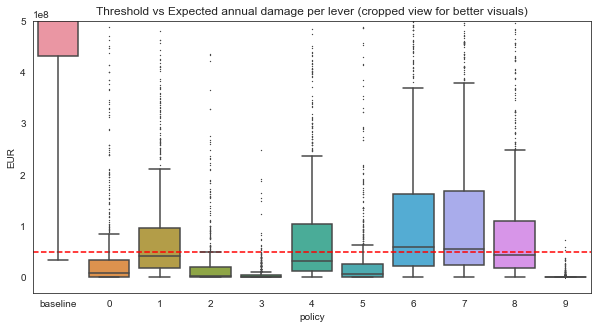

In [14]:
# check threshold vs distribution of expected annual damage per lever
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=damage, x='policy', y='Expected Annual Damage', fliersize=0.5)
ax.hlines(THRESHOLD_DAMAGE, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', linestyles='--', lw=1.5)
ax.set_title('Threshold vs Expected annual damage per lever (cropped view for better visuals)')
ax.set_ylabel('EUR')
ax.set_ybound(-3e7, 5e8) # zoom-in for better visuals

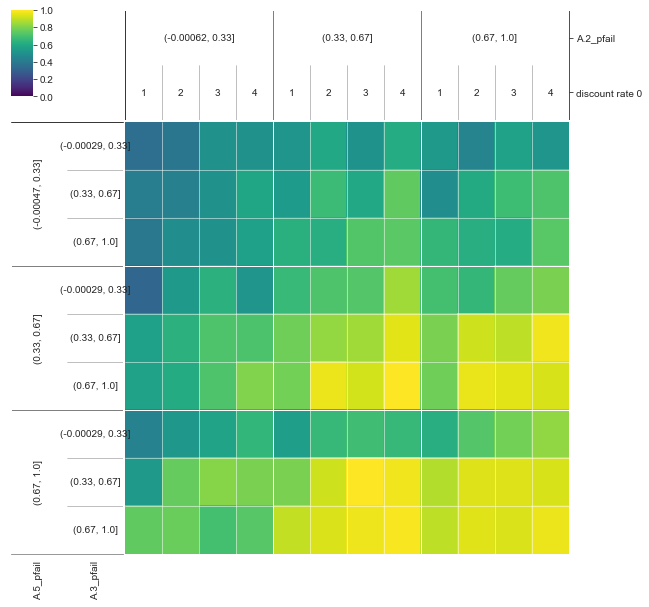

In [15]:
x = experiments.drop(columns = [l.name for l in dike_model.levers]+['policy', 'model'])
y = outcomes['Expected Annual Damage'] < THRESHOLD_DAMAGE

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3, bin_labels=True)
plt.show()

In [16]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 7112 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.126, coverage: 0.17716535433070865, density: 1.0 restricted_dimensions: 8


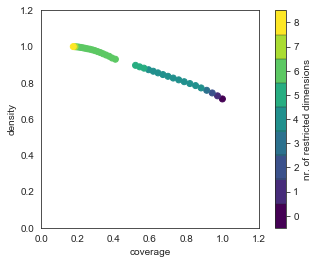

In [17]:
box1.show_tradeoff()
plt.show()

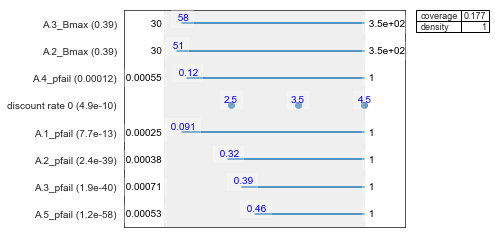

In [18]:
box1.inspect(style='graph')
plt.show()

### b. Expected Number of Deaths < 0.005 person

From the boxplots and pairwise scatterplots, we learned that *Expected Number of Deaths* varies much across the levers introduced, although all sampled levers significantly reduce the outcome to < 0.5 person. Except for policy 6 and 7 whose number of deaths are higher than other sampled cases, the outcome of deaths roughly has a mean value of 0.005 person. We therefore use this as the threshold for subspace partitioning of number of deaths.

The dimensional stacking plot and PRIM show that the most infuential uncertainties for expected number of deaths are the dike failure probabilities (*pfail*). 

The results suggest that an outcome of expected number of deaths < 0.005 person is likely to occur at scenarios with stricter requirements on pfail at Zutphen (A.3), pfail at Deventer (A.5), pfail at Cortenoever (A.2) and pfail at Doesburg (A.1). Scenarios where much higher pfail's at these locations occur tend to result in less deaths.

In [19]:
# threshold for subspace partitioning for deaths
THRESHOLD_DEATHS = 0.005

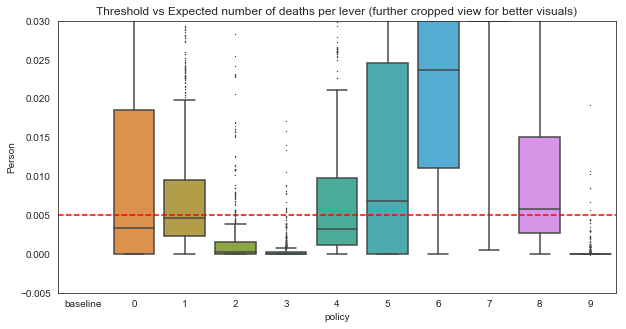

In [20]:
# check threshold vs distribution of expected number of deaths per lever
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=deaths, x='policy', y='Expected Number of Deaths', fliersize=0.5)
ax.hlines(THRESHOLD_DEATHS, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', linestyles='--', lw=1.5)
ax.set_title('Threshold vs Expected number of deaths per lever (further cropped view for better visuals)')
ax.set_ylabel('Person')
ax.set_ybound(-0.005, 0.03) # futher zoom-in for better visuals

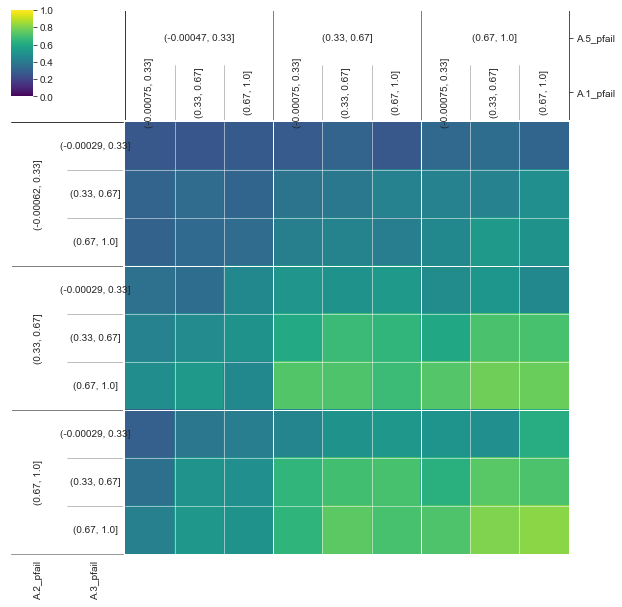

In [21]:
x = experiments_w0.drop(columns = [l.name for l in dike_model.levers]+['policy', 'model'])
y = outcomes_w0['Expected Number of Deaths'] < THRESHOLD_DEATHS

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3, bin_labels=True)
plt.show()

In [22]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.6) # with a lower threshold for convergence
box2 = prim_alg.find_box()

[MainProcess/INFO] 11000 points remaining, containing 5609 cases of interest
[MainProcess/INFO] mean: 0.8101851851851852, mass: 0.05890909090909091, coverage: 0.09359957211624176, density: 0.8101851851851852 restricted_dimensions: 6


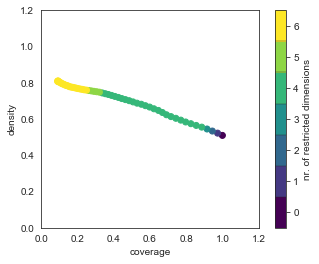

In [23]:
box2.show_tradeoff()
plt.show()

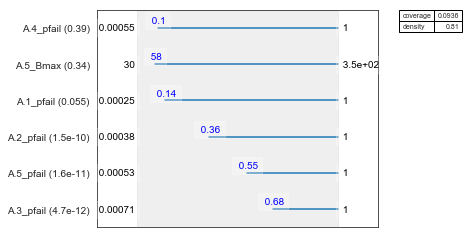

In [24]:
box2.inspect(style='graph')
plt.show()

## 4, Distribution of Costs and Risks

Finally, let's look at how the outcomes are distributed throughout the 5 locations for the zero policy under 1,000 scenarios. So we will run experiments with the problem formulation no. 3 and plot the outcomes. This allows to look at the problem from different perspectives.

All policy costs are zero, thus the total cost per location only include damage. 

The results suggest that the greatest risk in terms of deaths and damage is at A1, followed by A3 which has some important outliers. At A2 the risk is significantly lower. A5 has some outliers but in general a quite low risk. A4 has the lowest risk among the 5 locations. Therefore, as expected, the upstream locations have the highest flood risk  whereas the downstream locations will be less affected by deaths and damage.

In [25]:
ID_PF = 3    # assign problem_formulation_id: disaggregated over locations
NR_STEPS = 2 # assign number of planning steps
dike_model_disagg, planning_steps = get_model_for_problem_formulation(ID_PF, NR_STEPS)

In [32]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=ref_scenarios, # the same 1,000 sampled scenarios
                                            policies=ref_policy0) # zero policy

save_results(results, './results/open_exploration_uncertainties_policy0_2steps_disaggregated.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\anja\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\results\open_exploration_uncertainties_policy0_2steps_disaggregated.tar.gz


Wall time: 9min 38s


In [22]:
results_policy0dis = load_results('./results/open_exploration_uncertainties_policy0_2steps_disaggregated.tar.gz')

_, outcomes_policy0dis = results_policy0dis

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_policy0_2steps_disaggregated.tar.gz


### Boxplot of the disaggregated outcomes 

Text(0, 0.5, 'EUR / year')

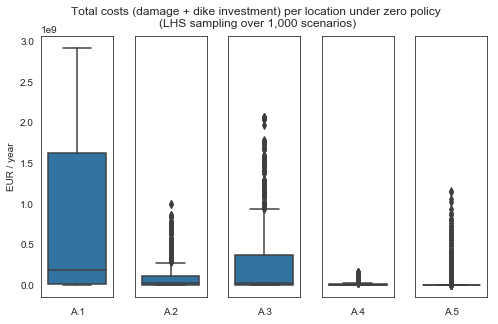

In [43]:
# plot for total costs per location (=damage + dike investment costs)
fig, axes = plt.subplots(1, 5, figsize=(8, 5), sharey=True)
plt.subplots_adjust(wspace=0.3, top=0.85)

kpis = [key.name for key in dike_model_disagg.outcomes
        if 'Total Costs' in key.name and 'RfR' not in key.name] 

for kpi in kpis:
    sns.boxplot(pd.Series(outcomes_policy0dis[kpi]), orient='v',
                ax=axes[kpis.index(kpi)])
    axes[kpis.index(kpi)].set_xlabel(kpi.split(' ')[0]) # label only location

fig.suptitle('Total costs (damage + dike investment) per location under zero policy \n(LHS sampling over 1,000 scenarios)', 
             y=0.93, fontsize=12)
axes[0].set_ylabel('EUR / year') # set units for damage and costs

Text(0, 0.5, 'Person / year')

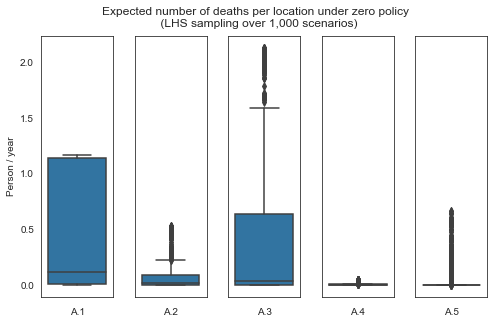

In [42]:
# plot for number of deaths per location
fig, axes = plt.subplots(1, 5, figsize=(8, 5), sharey=True)
plt.subplots_adjust(wspace=0.3, top=0.85)

kpis = [key.name for key in dike_model_disagg.outcomes
        if 'Expected Number of Deaths' in key.name] 

for kpi in kpis:
    sns.boxplot(pd.Series(outcomes_policy0dis[kpi]), orient='v',
                ax=axes[kpis.index(kpi)])
    axes[kpis.index(kpi)].set_xlabel(kpi.split('_')[0]) # label only location

fig.suptitle('Expected number of deaths per location under zero policy \n (LHS sampling over 1,000 scenarios)', 
             y=0.93, fontsize=12)
axes[0].set_ylabel('Person / year') # set units for deaths

## Appendix

#### *The ten sampled levers*

In [21]:
levers = experiments.loc[:, [l.name for l in dike_model.levers]]
levers = levers.drop_duplicates()
levers.index = experiments.policy.unique() # align with policy no.
levers.T # transpose for seeing all levers

,0,1,2,3,4,5,6,7,8,9
0_RfR 0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
0_RfR 1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1_RfR 0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1_RfR 1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2_RfR 0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2_RfR 1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3_RfR 0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3_RfR 1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
4_RfR 0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4_RfR 1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
